This notebook includes functions for plotting the figures reported in the paper.

In [4]:
import simsom.config_vals as configs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import pandas as pd
import os
import glob
import json

# Helpers 

## Read and reformat data

In [20]:
TARGET_PARAMS = [
    "theta",
    "beta",
    "gamma",
    "mu",
    "epsilon",
    "phi",
    "rho",
    "graph_gml",
    "targeting_criterion",
    "quality",
]


def read_data(res_dir, folders, keep_file_name=False):
    """
    Read results of multiple runs into 1 df. 
    Result is a .json file containing target_params as specified below. 
    'quality' is stored in a list. If there are multiple runs, df contains cols: 'quality_0', 'quality_1', etc.
    
    Params: 
        - folders (list of str): result folders
        - res_dir (str): directory containing result folders 
        - keep_file_name (bool): make a file_name column. To distinguish the type of exp if needed
    Outputs:
        - dfs (list of dataframes): each dataframe is the results from a call to driver.py
    """

    dfs = []

    for idx, folder in enumerate(folders):
        data = []
        for fpath in glob.glob(os.path.join(res_dir, folder, "*.json")):
            exp_res = json.load(open(fpath, "r"))

            # In case error in exp and quality is empty
            if len(exp_res["quality"]) == 0:
                continue

            row = {}
            for param in TARGET_PARAMS:
                # if there are multiple qualities, make 'quality' col with a suffix, e.g: quality_00
                if param == "quality":
                    for jdx, qual in enumerate(exp_res["quality"]):
                        row[f"quality_{jdx}"] = qual
                else:
                    row[param] = exp_res[param]

            if keep_file_name:
                row["file_name"] = os.path.basename(fpath)

            data += [row]

        df = pd.DataFrame.from_records(data)
        df["targeting_criterion"] = df["targeting_criterion"].apply(
            lambda x: "none" if x is None else x
        )

        dfs += [df]
    return dfs

In [50]:
def get_95_ci(values):
    # return mean-95ci, mean+95ci
    lower, upper = st.t.interval(
        0.95, len(values) - 1, loc=np.mean(values), scale=st.sem(values)
    )
    ci = (upper - lower) / 2
    return ci


def get_mean(df, col_name_prefix="quality"):
    # df has to have cols with "col_name_prefix" prefix
    # get mean column-wise
    qual_cols = [col for col in df.columns if col_name_prefix in col]
    df[f"mean_{col_name_prefix}"] = df.loc[:, qual_cols].mean(axis=1)
    df[f"std_{col_name_prefix}"] = df.loc[:, qual_cols].std(axis=1)
    df[f"ci_{col_name_prefix}"] = df.apply(
        lambda x: get_95_ci([x[col] for col in qual_cols]), axis=1
    )
    return df


def get_relative(df, baseline, col_name_prefix="quality"):
    """
        Divides the values of the columns matching a prefix by a baseline  
    """

    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    for idx, col in enumerate(quality_cols):
        df[f"relative_{col_name_prefix}_{idx}"] = df[col].apply(lambda x: x / baseline)
    return df

In [51]:
## HELPER FOR BOXPLOT

def reindex_cols(df, col_name_prefix="quality"):

    """
        Reset cols with the same prefix, e.g, quality_x_1, quality_y, etc. 
        so that they're indexed correctly, e.g, quality_1, quality_2, etc. 
        Inputs:
             - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
        Outputs:
        - df with correctly indexed cols
    """

    # de-duplicate columns first. Solution from https://stackoverflow.com/a/24686572
    cols = pd.Series(df.columns)

    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [
            dup + "." + str(i) if i != 0 else dup for i in range(sum(cols == dup))
        ]

    # rename the columns with the cols list.
    df.columns = cols

    # Reindex quality columns
    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    rename_dict = {
        col: f"{col_name_prefix}_{idx}" for idx, col in enumerate(quality_cols)
    }
    df = df.rename(columns=rename_dict)
    return df


def pivot_results(df, col_name_prefix="quality"):

    """
        Returns long-format df. 
        Inputs:
             - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
        Outputs:
        - df with only 1 quality column: "col_name_prefix_"
    """

    df["id"] = df.index
    df_long = pd.wide_to_long(
        df, [f"{col_name_prefix}_"], i="id", j="run_no"
    ).reset_index()

    return df_long


## Format violin plot

In [52]:
# orange, blue, teal, purpple, yellow, pink
BLUEPALETTE = ["#F18447", "#3863AC", "#209B8A", "#550F6B", "#F8D625", "#BC3684"]


def patch_violinplot(ax, palette=BLUEPALETTE, n=1, alpha=1, multicolor=True):
    """
    Recolor the outlines of violin patches using a palette
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PolyCollection

    violins = [art for art in ax.get_children() if isinstance(art, PolyCollection)]
    for i in range(len(violins)):
        if multicolor is False:
            violins[i].set_edgecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_edgecolor(colors[i])
        violins[i].set_alpha(alpha)


def point_violinplot(
    ax, palette=BLUEPALETTE, n=1, pointsize=200, edgecolor="white", multicolor=True
):
    """
    Recolor points in the plot based on the violin facecolor
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - edgecolor (str): point outline color
    - pointsize (int): point size 
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PathCollection

    violins = [art for art in ax.get_children() if isinstance(art, PathCollection)]
    for i in range(len(violins)):
        violins[i].set_sizes([pointsize])  # size
        violins[i].set_edgecolor(edgecolor)  # outline
        violins[i].set_linewidth(1.5)
        if multicolor is False:
            violins[i].set_facecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_facecolor(colors[i])


# Setting global variables 

In [53]:
# Directory containing experiment results
RES_DIR = "results"

# Directory to save figures 
PLOT_DIR = "figures"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

# Styling
plt.style.use('stylesheet.mplstyle')
PALETTE = ["#550F6B", "#F8D625", "#BC3684", "#F18447", "#3863AC", "#209B8A"]
sns.set_palette(PALETTE)

THETA = configs.THETA_SWIPE
PHI = [np.round(i,1) for i in configs.PHI_SWIPE] #round to 1 since np range gives many decimals
GAMMA = configs.GAMMA

In [58]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Baseline results

In [57]:

data = json.load(open('results/baseline/baseline.json','r'))
df = pd.DataFrame.from_records(data)
baseline =get_mean(df, col_name_prefix="quality")
baseline_val =baseline['mean_quality'].mean()
print(f'Overall quality when there is no bots: {np.round(baseline_val,2)}')

Overall quality when there is no bots: 0.48


# Shuffle 
Effects of network structure on Quality

In [173]:
#SHUFFLE
data , = read_data(RES_DIR, ['shuffle'], keep_file_name=True)

# refer shuffling strategies from file names
data['shuffle'] = data['file_name'].apply(lambda x: x.split('_shuffle__')[0])
shuffle = reindex_cols(data, col_name_prefix="quality").reset_index(drop=True) #remove duplicated index
shuffle.head()

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,...,quality_3,quality_4,quality_5,quality_6,alpha,file_name,quality_7,quality_8,quality_9,shuffle
0,1,0.05,0.0001,0.5,0.0001,0.0,0.8,/N/slate/baotruon/marketplace/data/igraph/shuf...,hubs,0.482677,...,0.481110,0.492061,0.484758,0.481681,15,hub_shuffle__hubs0.json,NaN,NaN,NaN,hub
1,1,0.05,0.0001,0.5,0.0001,0.0,0.8,/N/slate/baotruon/marketplace/data/igraph/shuf...,none,0.491460,...,0.483025,0.476309,0.483866,0.488623,15,all_shuffle__None0.json,NaN,NaN,NaN,all
2,1,0.05,0.1000,0.5,0.0001,0.0,0.8,/N/slate/baotruon/marketplace/data/igraph/shuf...,hubs,0.236598,...,0.243060,0.248028,0.244578,0.236545,15,community_shuffle__hubs3.json,NaN,NaN,NaN,community
3,1,0.05,0.1000,0.5,0.0001,0.0,0.8,/N/slate/baotruon/marketplace/data/igraph/shuf...,conservative,0.328416,...,0.337814,0.328097,0.330753,0.336562,15,community_shuffle__conservative3.json,NaN,NaN,NaN,community
4,1,0.05,0.0001,0.5,0.0001,0.0,0.8,/N/slate/baotruon/marketplace/data/igraph/shuf...,conservative,0.482949,...,0.487917,0.487077,0.484403,0.495070,15,all_shuffle__conservative0.json,NaN,NaN,NaN,all


In [174]:
#NO SHUFFLE
data , = read_data(RES_DIR, ['vary_gamma'])
data = reindex_cols(data, col_name_prefix="quality").reset_index(drop=True) #remove duplicated index

noshuffle = data
noshuffle['shuffle']='None'

In [175]:
data = pd.concat([noshuffle, shuffle]).reset_index(drop=True)
data = get_relative(data, baseline_val, col_name_prefix="quality")
results = pivot_results(data, col_name_prefix="relative_quality")

Plot data for default values $\gamma=0.01$

In [176]:
plot_data = results[(results.gamma==0.01) & (results.targeting_criterion=='none')]
plot_data.head()

,id,run_no,theta,quality_9,quality_7,graph_gml,quality_8,mu,epsilon,phi,...,quality_1,quality_4,targeting_criterion,rho,quality_3,quality_6,quality_2,gamma,quality_0,relative_quality_
8,8,0,1,0.404591,0.415683,/N/slate/baotruon/marketplace/data/igraph/vary...,0.399861,0.5,0.0001,0.0,...,0.384954,0.389396,none,0.8,0.401314,0.382868,0.390945,0.01,0.392640,0.815936
40,40,0,1,0.444510,0.426708,/N/slate/baotruon/marketplace/data/igraph/shuf...,0.446665,0.5,0.0001,0.0,...,0.431148,0.396200,none,0.8,0.431006,0.439257,0.426898,0.01,0.432699,0.899182
61,61,0,1,0.401603,0.400263,/N/slate/baotruon/marketplace/data/igraph/shuf...,0.396684,0.5,0.0001,0.0,...,0.408672,0.408132,none,0.8,0.398967,0.383922,0.390816,0.01,0.408393,0.848672
62,62,0,1,0.433547,0.435409,/N/slate/baotruon/marketplace/data/igraph/shuf...,0.441231,0.5,0.0001,0.0,...,0.431961,0.442074,none,0.8,0.441768,0.438826,0.427208,0.01,0.427850,0.889106
80,8,1,1,0.404591,0.415683,/N/slate/baotruon/marketplace/data/igraph/vary...,0.399861,0.5,0.0001,0.0,...,0.384954,0.389396,none,0.8,0.401314,0.382868,0.390945,0.01,0.392640,0.799965


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

communities vs. hubs+communities: Welch's t-test independent samples, P_val:1.247e-05 t=6.094e+00
hubs vs. communities: Welch's t-test independent samples, P_val:8.345e-05 t=-5.124e+00
random vs. hubs: Welch's t-test independent samples, P_val:6.729e-07 t=8.559e+00
random vs. hubs+communities: Welch's t-test independent samples, P_val:7.685e-08 t=1.009e+01


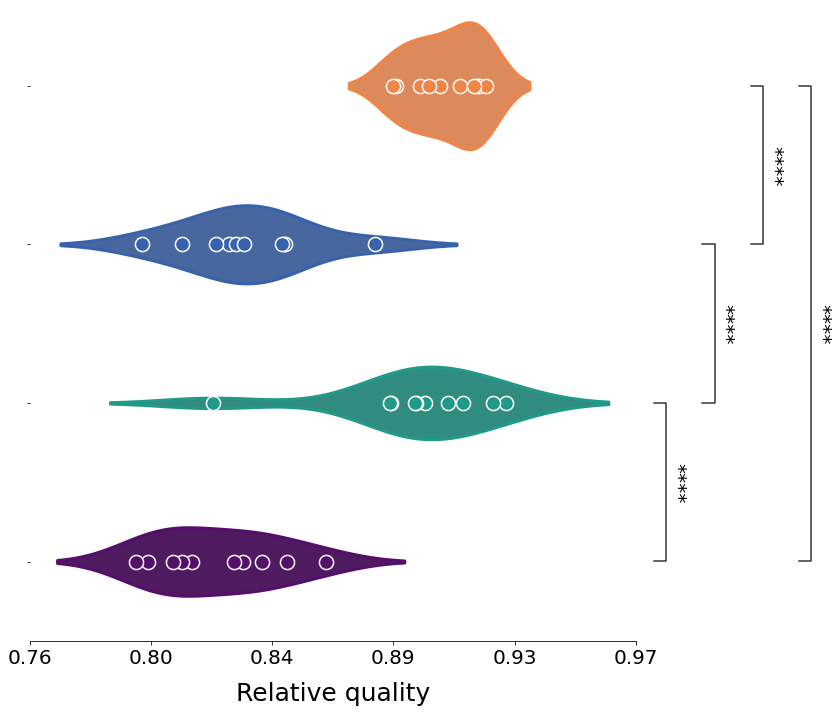

In [177]:
from statannotations.Annotator import Annotator
fpath = os.path.join(PLOT_DIR, "shuffle")
fig,ax = plt.subplots(figsize=(12,10)) 
ax.xaxis.set_major_locator(plt.LinearLocator(6))
ax.xaxis.set_major_formatter("{x:.02f}")
order=['random', 'hubs', 'communities', 'hubs+communities']

# Rename shuffles
plot_data['shuffle'] = plot_data['shuffle'].apply(lambda x: 'random' if x=='all' else x)
plot_data['shuffle'] = plot_data['shuffle'].apply(lambda x: 'hubs+communities' if x=='None' else x)
plot_data['shuffle'] = plot_data['shuffle'].apply(lambda x: 'hubs' if x=='hub' else x)
plot_data['shuffle'] = plot_data['shuffle'].apply(lambda x: 'communities' if x=='community' else x)

violin = sns.violinplot(data=plot_data, y="shuffle", x="relative_quality_", 
                        order=order, 
#                         scale='width',
                        inner="point", palette=BLUEPALETTE)

pairs=[('hubs+communities', 'communities'), 
       ('hubs+communities', 'random'),
       ('hubs', 'communities'), 
        ('hubs','random')
        ]
annotator = Annotator(ax, pairs, data=plot_data, y="shuffle", x="relative_quality_", 
                      orient='h',
                      order=order
                     )
annotator.configure(test='t-test_welch', text_format='star', loc='outside', fontsize=20, 
                    # comparisons_correction="bonferroni"
                    comparisons_correction=None
                   )
annotator.apply_and_annotate()

violin.set(yticklabels=[])
violin.tick_params(axis='x', labelsize=20)
violin.tick_params(axis='y', labelsize=20)
violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize = 25, labelpad=14)
patch_violinplot(ax, palette=BLUEPALETTE, n=4)
point_violinplot(ax, palette=BLUEPALETTE, n=4)
sns.despine(top = True, left = True, bottom=False)
#Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf") 
    fig.savefig(f"{fpath}.png") 
else:
    plt.show()

# Alpha

In [68]:
folders= ['vary_alpha']
TARGET_PARAMS.append('alpha')

data , = read_data(RES_DIR, folders)
data = reindex_cols(data, col_name_prefix="quality")
alphadata = pivot_results(data, col_name_prefix = "quality")
alphadata = alphadata.sort_values(by='alpha')
alphadata.head()

,id,run_no,theta,beta,alpha,graph_gml,targeting_criterion,rho,mu,epsilon,phi,gamma,quality_
4,4,0,1,0.05,1,/N/slate/baotruon/marketplace/data/igraph/vary...,none,0.8,0.5,0.0001,0.0,0.01,0.298196
36,4,4,1,0.05,1,/N/slate/baotruon/marketplace/data/igraph/vary...,none,0.8,0.5,0.0001,0.0,0.01,0.312435
28,4,3,1,0.05,1,/N/slate/baotruon/marketplace/data/igraph/vary...,none,0.8,0.5,0.0001,0.0,0.01,0.300632
20,4,2,1,0.05,1,/N/slate/baotruon/marketplace/data/igraph/vary...,none,0.8,0.5,0.0001,0.0,0.01,0.273130
12,4,1,1,0.05,1,/N/slate/baotruon/marketplace/data/igraph/vary...,none,0.8,0.5,0.0001,0.0,0.01,0.285202


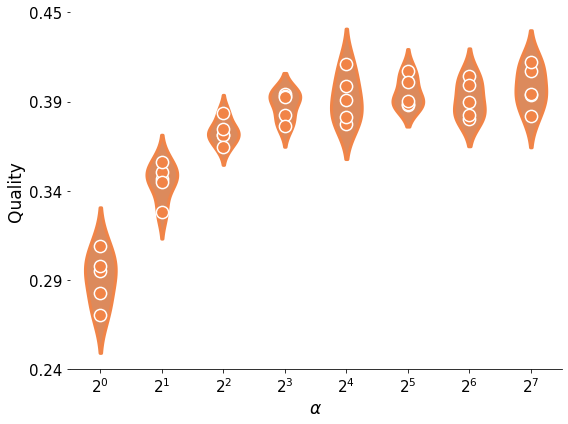

In [69]:
fpath = os.path.join(PLOT_DIR, "alpha")  
color = "#F18447" #orange

fig,ax=plt.subplots(figsize=(8,6))
ax.yaxis.set_major_locator(plt.LinearLocator(5))
ax.yaxis.set_major_formatter("{x:.02f}")
violin = sns.violinplot(data=alphadata, x="alpha", y="quality_",
                        ax=ax,
                        scale='width',
                        width=0.5,
                        inner="point", 
                        color=color)

#Formatting
ticks = range(len(alphadata.alpha.unique()))
violin.set_xticks(ticks)
violin.set_xticklabels([f'$2^{i}$' for i in ticks])

violin.set_xlabel(f"$\\alpha$")
violin.set_ylabel("Quality")

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor='white', multicolor=False)

sns.despine(top = True, right = True, left=True)

#Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf") 
    fig.savefig(f"{fpath}.png") 
else:
    plt.show()

# Mu

In [41]:
# Read data
data , = read_data(RES_DIR, ['vary_mu'])
data = reindex_cols(data, col_name_prefix="quality")
mudata = pivot_results(data, col_name_prefix = "quality")

mudata = mudata.sort_values(by="mu")
mudata.head()

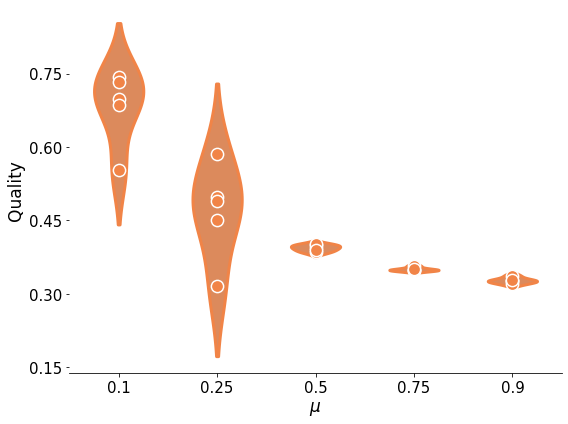

In [70]:
fpath = os.path.join(PLOT_DIR, "mu")  
color = "#F18447" #orange

fig,ax=plt.subplots(figsize=(8,6))
ax.yaxis.set_major_locator(plt.MaxNLocator(7))
ax.yaxis.set_major_formatter("{x:.02f}")
violin = sns.violinplot(data=mudata, x="mu", y="quality_",
                        ax=ax,
                        scale='width',
                        width=0.5,
                        inner="point", 
                        color=color)
# Formatting
ax.yaxis.set_major_locator(plt.MaxNLocator(6))

violin.set_xlabel(f"$\\mu$")
violin.set_ylabel("Quality")

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor='white', multicolor=False)
sns.despine(top = True, right = True, left=True)

#Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf") 
    fig.savefig(f"{fpath}.png") 
else:
    plt.show()

# Bot params

## Read data 
Data is a subset of joint effect experiments

In [142]:
# THETAPHI
data , = read_data(RES_DIR, folders=['thetaphi'])
# Reset quality cols 
data= reindex_cols(data, col_name_prefix="quality")
# Remove duplicate col names and index
thetaphi = data.loc[:,~data.columns.duplicated()].copy().reset_index(drop=True)

thetaphi.head()

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,alpha
0,4,0.05,0.01,0.5,0.0001,0.0,0.8,/N/slate/baotruon/marketplace/data/igraph/vary...,none,0.314663,0.324465,0.326651,0.321109,0.328148,15
1,4,0.05,0.01,0.5,0.0001,1.0,0.8,/N/slate/baotruon/marketplace/data/igraph/vary...,none,0.253570,0.231191,0.245040,NaN,NaN,15
2,8,0.05,0.01,0.5,0.0001,0.6,0.8,/N/slate/baotruon/marketplace/data/igraph/vary...,none,0.206091,0.209840,0.209693,NaN,NaN,15
3,16,0.05,0.01,0.5,0.0001,0.1,0.8,/N/slate/baotruon/marketplace/data/igraph/vary...,none,0.232307,0.214956,0.227916,NaN,NaN,15
4,2,0.05,0.01,0.5,0.0001,0.6,0.8,/N/slate/baotruon/marketplace/data/igraph/vary...,none,0.297468,0.284543,0.285383,NaN,NaN,15


In [166]:
## PHI GAMMA
data , = read_data(RES_DIR, folders=['phigamma'])
# Reset quality cols 
data= reindex_cols(data, col_name_prefix="quality")

# Remove duplicate col names and index
phigamma = data.loc[:,~data.columns.duplicated()].copy().reset_index(drop=True)
phigamma.head()

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,alpha,quality_3,quality_4
0,1,0.05,0.1000,0.5,0.0001,1.0,0.8,/N/slate/baotruon/marketplace/data/igraph/vary...,none,0.167300,0.166503,0.163546,15,NaN,NaN
1,1,0.05,0.0001,0.5,0.0001,0.2,0.8,/N/slate/baotruon/marketplace/data/igraph/vary...,none,0.480780,0.475175,0.466505,15,NaN,NaN
2,1,0.05,0.0010,0.5,0.0001,0.6,0.8,/N/slate/baotruon/marketplace/data/igraph/vary...,none,0.415106,0.437513,0.441066,15,NaN,NaN
3,1,0.05,0.0010,0.5,0.0001,0.4,0.8,/N/slate/baotruon/marketplace/data/igraph/vary...,none,0.433133,0.444591,0.447141,15,NaN,NaN
4,1,0.05,0.0001,0.5,0.0001,0.0,0.8,/N/slate/baotruon/marketplace/data/igraph/vary...,none,0.479664,0.477726,0.478390,15,0.48198,0.474257


In [162]:
## THETAGAMMA 
data,  = read_data(RES_DIR, folders=['thetagamma'])
# Reset quality cols 
data= reindex_cols(data, col_name_prefix="quality")

# Remove duplicate col names and index
thetagamma = data.loc[:,~data.columns.duplicated()].copy().reset_index(drop=True)
thetagamma.head()

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,alpha
0,4,0.05,0.0001,0.5,0.0001,0.0,0.8,/N/slate/baotruon/marketplace/data/igraph/vary...,none,0.475578,0.480570,0.481144,0.472569,0.483461,15
1,16,0.05,0.0010,0.5,0.0001,0.0,0.8,/N/slate/baotruon/marketplace/data/igraph/vary...,none,0.436496,0.426920,0.428162,0.433081,0.432792,15
2,1,0.05,0.0001,0.5,0.0001,0.0,0.8,/N/slate/baotruon/marketplace/data/igraph/vary...,none,0.479915,0.473845,0.490928,0.471968,0.475558,15
3,1,0.05,0.0010,0.5,0.0001,0.0,0.8,/N/slate/baotruon/marketplace/data/igraph/vary...,none,0.467759,0.472296,0.468431,0.475883,0.464001,15
4,16,0.05,0.0001,0.5,0.0001,0.0,0.8,/N/slate/baotruon/marketplace/data/igraph/vary...,none,0.477165,0.479158,0.472952,0.469949,0.468296,15


## Single param plots

In [145]:
## Helper
def draw_lines(ax, data, line_name="hub", marker="", linewidth=4, color="#F18447"):
    """
    Input: data=(x,y, err)
    line_name=['hub', 'none']
    err: tuple of mean+error, mean-error. Could be std or CI95
    """
    x, y, y_err = data
    ax.plot(x, y, label=line_name, marker=marker, color=color, linewidth=linewidth)
    ax.fill_between(
        x,
        np.subtract(np.array(y), np.array(y_err)),
        np.add(np.array(y), np.array(y_err)),
        color=color,
        alpha=0.3,
    )
    return

Subsetting data (only plot default values for each panel)

In [146]:
# VARYING GAMMA
vary_gamma = pd.merge(phigamma[phigamma.phi==0], thetagamma[thetagamma.theta==1], on=['theta', 'beta','gamma','phi'])
vary_gamma = get_relative(vary_gamma, baseline_val, col_name_prefix="quality")
vary_gamma = get_mean(vary_gamma, col_name_prefix = "relative_quality")
x = vary_gamma['gamma']
y = vary_gamma['mean_relative_quality']
err = vary_gamma['ci_relative_quality']
gammadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

# VARYING PHI
vary_phi = pd.merge(thetaphi[thetaphi.theta==1],phigamma[phigamma.gamma==0.01], on=['theta', 'beta','gamma','phi'])
vary_phi = get_relative(vary_phi, baseline_val, col_name_prefix="quality")
vary_phi = get_mean(vary_phi, col_name_prefix = "relative_quality")
x = [0.1*i for i in vary_phi['phi']]
y = vary_phi['mean_relative_quality']
err = vary_phi['ci_relative_quality']
phidata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

# VARYING THETA
vary_theta = pd.merge(thetaphi[thetaphi.phi==0],thetagamma[thetagamma.gamma==0.01], on=['theta', 'beta','gamma','phi'])
vary_theta = get_relative(vary_theta, baseline_val, col_name_prefix="quality")
vary_theta = get_mean(vary_theta, col_name_prefix = "relative_quality")
x = vary_theta['theta']
y = vary_theta['mean_relative_quality']
err = vary_theta['ci_relative_quality']
thetadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

### Plot

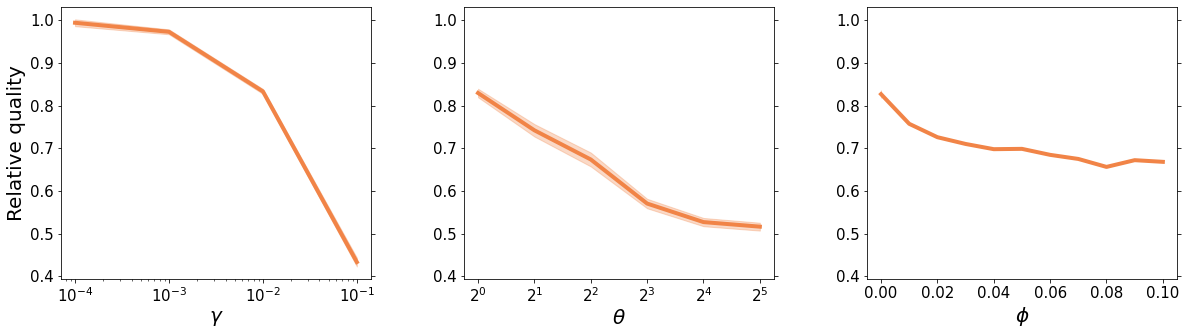

In [147]:
fpath = os.path.join(PLOT_DIR, "botparam")  
color = "#F18447" #orange

y_axis = 'Relative quality'
fig, axs = plt.subplots(1,3,figsize=(20,5), sharey=True) # same size with contour plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.style.use('stylesheet.mplstyle')


#GAMMA
ax = axs[0]
draw_lines(ax, gammadata, color=color)
ax.set_xlabel("$\\gamma$", fontsize=20)
ax.set_ylabel(y_axis, fontsize=20, labelpad=4)
ax.set_xscale('log')
ax.tick_params(labelleft=True, labelright=False,left=True, right=True)


#THETA
ax = axs[1]
draw_lines(ax, thetadata, color=color)
ax.set_xlabel("$\\theta$", fontsize=20, labelpad=4)
ax.set_xscale('log', base=2)
ax.tick_params(labelleft=True, labelright=False,left=True, right=True)
ax.xaxis.set_major_locator(plt.LogLocator(base=2, numticks=len(vary_theta['theta'])+1))
# ax.xaxis.set_major_locator(plt.MultipleLocator())

#PHI
ax = axs[2]
draw_lines(ax, phidata, color=color)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=4)
ax.tick_params(labelleft=True, labelright=False,left=True, right=True)

#Increase space between subplots to look nice with contour plot in a panel instead of tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)

if fpath is not None:
    plt.savefig(f"{fpath}.pdf")
    plt.savefig(f"{fpath}.png")
else:
    plt.show()

## Contour plots

### Data: Thetaphi

In [148]:
thetaphi = get_relative(thetaphi, baseline_val, col_name_prefix="quality")
thetaphi = get_mean(thetaphi, col_name_prefix = "relative_quality")

# drop duplicate & reshape
thetaphi = thetaphi.drop_duplicates(subset=['theta','phi'], keep='first')
thetaphi = thetaphi.pivot(index='theta', columns='phi', values='mean_relative_quality').reset_index()
thetaphi.head()

phi,theta,0.0,0.1,0.2,0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001,0.8,0.9,1.0
0,1,0.823089,0.747759,0.729006,0.711123,0.699886,0.707850,0.690290,0.671740,0.649171,0.673285,0.666195
1,2,0.733259,0.676325,0.648990,0.634831,0.608693,0.626885,0.600837,0.596249,0.605134,0.563884,0.578726
2,4,0.671234,0.584056,0.565105,0.532507,0.539577,0.534363,0.511447,0.528932,0.514204,0.516872,0.505527
3,8,0.560878,0.531023,0.482729,0.493488,0.479664,0.464420,0.433366,0.445564,0.434946,0.435710,0.432124
4,16,0.527473,0.467691,0.456769,0.426737,0.417820,0.412263,0.401047,0.387606,0.394171,0.384138,0.383878


In [149]:
# Pandas convert phi into np.float so we need to change column names to match with PHI
thetaphi.columns = ['theta']+PHI
thetaphi.head()

,theta,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,1,0.823089,0.747759,0.729006,0.711123,0.699886,0.707850,0.690290,0.671740,0.649171,0.673285,0.666195
1,2,0.733259,0.676325,0.648990,0.634831,0.608693,0.626885,0.600837,0.596249,0.605134,0.563884,0.578726
2,4,0.671234,0.584056,0.565105,0.532507,0.539577,0.534363,0.511447,0.528932,0.514204,0.516872,0.505527
3,8,0.560878,0.531023,0.482729,0.493488,0.479664,0.464420,0.433366,0.445564,0.434946,0.435710,0.432124
4,16,0.527473,0.467691,0.456769,0.426737,0.417820,0.412263,0.401047,0.387606,0.394171,0.384138,0.383878


In [150]:
tp_matrix = thetaphi.loc[:,PHI].values
#Check shape:
tp_matrix.shape 

(6, 11)

In [180]:
tp_matrix

array([[0.8230887 , 0.74775882, 0.7290057 , 0.71112296, 0.69988558,
        0.70785033, 0.69029038, 0.67173982, 0.6491713 , 0.67328539,
        0.66619456],
       [0.73325905, 0.6763246 , 0.64899042, 0.63483142, 0.60869254,
        0.62688519, 0.60083716, 0.59624861, 0.60513367, 0.56388397,
        0.5787264 ],
       [0.67123409, 0.58405604, 0.56510474, 0.53250701, 0.53957713,
        0.5343626 , 0.51144683, 0.52893248, 0.5142042 , 0.5168716 ,
        0.50552742],
       [0.56087842, 0.53102349, 0.4827289 , 0.49348755, 0.47966394,
        0.46442018, 0.43336571, 0.44556412, 0.43494596, 0.4357101 ,
        0.43212448],
       [0.52747294, 0.46769149, 0.45676882, 0.4267365 , 0.41782015,
        0.41226327, 0.40104658, 0.38760581, 0.3941706 , 0.38413826,
        0.38387751],
       [0.52544628, 0.48102854, 0.45209365, 0.43300907, 0.41519033,
        0.40746344, 0.40199775, 0.38473232, 0.390418  , 0.40180684,
        0.38827574]])

In [159]:
thetaphi

,theta,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,1,0.823089,0.747759,0.729006,0.711123,0.699886,0.707850,0.690290,0.671740,0.649171,0.673285,0.666195
1,2,0.733259,0.676325,0.648990,0.634831,0.608693,0.626885,0.600837,0.596249,0.605134,0.563884,0.578726
2,4,0.671234,0.584056,0.565105,0.532507,0.539577,0.534363,0.511447,0.528932,0.514204,0.516872,0.505527
3,8,0.560878,0.531023,0.482729,0.493488,0.479664,0.464420,0.433366,0.445564,0.434946,0.435710,0.432124
4,16,0.527473,0.467691,0.456769,0.426737,0.417820,0.412263,0.401047,0.387606,0.394171,0.384138,0.383878
5,32,0.525446,0.481029,0.452094,0.433009,0.415190,0.407463,0.401998,0.384732,0.390418,0.401807,0.388276


### Data: Thetagamma

In [163]:
thetagamma = get_relative(thetagamma, baseline_val, col_name_prefix="quality")
thetagamma = get_mean(thetagamma, col_name_prefix = "relative_quality")

# drop duplicate & reshape
thetagamma = thetagamma.drop_duplicates(subset=['theta','gamma'], keep='first')
thetagamma = thetagamma.pivot(index='theta', columns='gamma', values='mean_relative_quality').reset_index()
thetagamma.head()

gamma,theta,0.0001,0.001,0.01,0.1
0,1,0.994242,0.976019,0.835927,0.432603
1,2,0.995101,0.959099,0.750875,0.309886
2,4,0.994702,0.926577,0.676021,0.215199
3,8,0.990502,0.907169,0.579756,0.152144
4,16,0.983979,0.896671,0.526216,0.105486


In [179]:
tg_matrix

array([[0.99424158, 0.97601906, 0.83592733, 0.43260252],
       [0.99510054, 0.95909941, 0.75087514, 0.3098856 ],
       [0.99470246, 0.92657705, 0.67602118, 0.2151986 ],
       [0.99050213, 0.9071694 , 0.57975608, 0.15214432],
       [0.98397871, 0.89667059, 0.52621555, 0.10548599],
       [0.99295743, 0.90763683, 0.50686374, 0.1036627 ]])

In [164]:
tg_matrix = thetagamma.loc[:,GAMMA].values
tg_matrix.shape

(6, 4)

### Data: Phigamma

In [167]:
phigamma = get_relative(phigamma, baseline_val, col_name_prefix="quality")
phigamma = get_mean(phigamma, col_name_prefix = "relative_quality")

# drop duplicate & reshape
phigamma = phigamma.drop_duplicates(subset=['phi','gamma'], keep='first')
phigamma = phigamma.pivot(index='phi', columns='gamma', values='mean_relative_quality').reset_index()
phigamma.head()

gamma,phi,0.0001,0.001,0.01,0.1
0,0.0,0.994159,0.969971,0.830530,0.433707
1,0.1,0.983699,0.956408,0.766769,0.379524
2,0.2,0.985328,0.914810,0.722784,0.382089
3,0.3,0.985161,0.914188,0.709021,0.376902
4,0.4,0.984142,0.917724,0.695761,0.361630


In [168]:
pg_matrix = phigamma.loc[:,GAMMA].values
pg_matrix.shape

(11, 4)

### Plot

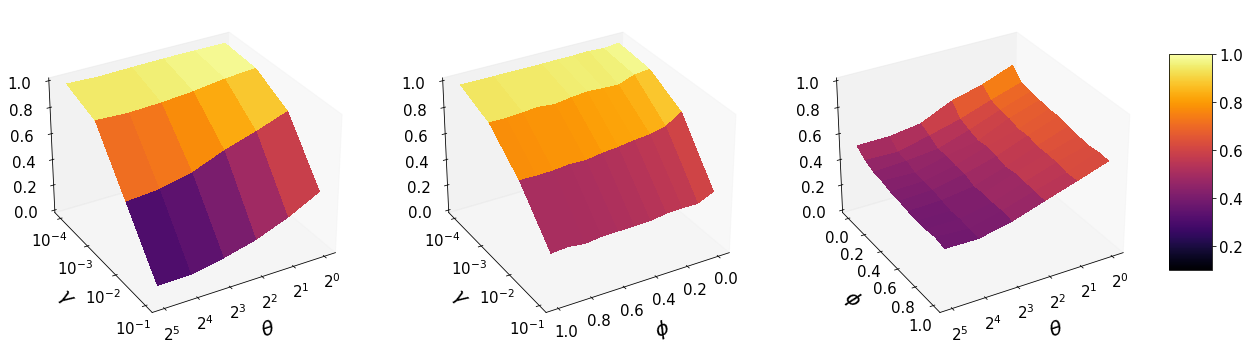

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mticker
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Matplotlib plot surface doesn't support plotting log scale yet 
# calling ax.zaxis._set_scale('log') only labels the axis in logarithm scale but not actually plotting in logarithm scale
# Solution 1: convert to log scale (line 36) then use a custom formatter function (line 14)
# from https://stackoverflow.com/a/67774238

def log_tick_formatter(val, pos=None, base=2):
    return f"${base}^{{{val:g}}}$" 
  
fpath = os.path.join(PLOT_DIR, "joint")  
cmap = plt.get_cmap("inferno")
fig, axs = plt.subplots(1,3, subplot_kw={"projection": "3d"}, figsize=(20, 6))

# Get range for plotting shared color bar
min_qual = min(min(tp_matrix.ravel()), min(tg_matrix.ravel()), min(pg_matrix.ravel()))
max_qual = max(max(tp_matrix.ravel()), max(tg_matrix.ravel()), max(pg_matrix.ravel()))
VMIN=np.round(min_qual,2)
VMAX=np.round(max_qual,2)

# For these exps we only plot a short range of theta
THETA_SHORT = [1, 2, 4, 8, 16, 32, 64]

## THETAGAMMA              
X = THETA_SHORT
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = tg_matrix.T

# PLOT SURFACE
ax=axs[0]
surf = ax.plot_surface(np.log2(X), np.log10(Y), Z, cmap=cmap, linewidth=0, antialiased=False, 
                           vmin=VMIN, vmax=VMAX)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda val,pos: log_tick_formatter(val,base=10)))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis='y', nbins=len(GAMMA)) #Set num ticks
ax.set_ylabel(f"$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)


## PHIGAMMA              
ax=axs[1]

X=PHI
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = pg_matrix.T

# PLOT
surf = ax.plot_surface(X, np.log10(Y), Z, cmap=cmap, linewidth=0, antialiased=False, 
                           vmin=VMIN, vmax=VMAX
                          )

# FORMATTING
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.xaxis.set_major_formatter("{x:.01f}")

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda val,pos: log_tick_formatter(val,base=10)))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis='y', nbins=len(GAMMA)) # Set num ticks, 'y', 'x' or 'both'
ax.set_ylabel("$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=13)

# Add a color bar which maps values to colors.
cbar_ax = fig.add_axes([0.92, .27, .03, .5])# x,y,width, height
fig.colorbar(surf, shrink=0.7, aspect=10, 
             cax=cbar_ax
            )


## THETAPHI
X = THETA_SHORT
Y = PHI
X, Y = np.meshgrid(X, Y)
Z = tp_matrix.T

# PLOT SURFACE
ax=axs[2]
surf = ax.plot_surface(np.log2(X), Y, Z, cmap=cmap, linewidth=0, antialiased=False, 
                           vmin=VMIN, vmax=VMAX)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_formatter("{x:.01f}")
# ax.set_zlabel(f"Relative Quality", fontsize=20, labelpad=20, rotation=90)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)
ax.set_ylabel(f"$\\phi$", fontsize=20, labelpad=13)


# rotate the axes and update
for ax in axs:
    ax.tick_params(axis="z", which="major", pad=10)
    ax.set_zlim(0,1)
    ax.zaxis.set_major_locator(plt.MaxNLocator(5))
    ax.zaxis.set_major_formatter("{x:.01f}")
    ax.grid(False)
    ax.view_init(30, 60)

plt.draw()
# Saving
if fpath is not None:
    plt.savefig(f"{fpath}.pdf", dpi=300)
    plt.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()

# Targeting

### Add vary gamma results here

Results for gamma=0.01 are mostly insignificant. Plotting gamma==0.1

In [48]:
dfs = read_data(RES_DIR, folders=["vary_gamma"])
data = dfs[0]
data = data[data.gamma == 0.1]
data = reindex_cols(data, col_name_prefix="quality")
data = get_relative(data, baseline_val, col_name_prefix="quality")
targetdata = pivot_results(data, col_name_prefix="relative_quality")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

random vs. hubs: Welch's t-test independent samples, P_val:2.053e-04 t=-4.981e+00
random vs. misinformation: Welch's t-test independent samples, P_val:7.296e-06 t=-6.759e+00
random vs. liberal: Welch's t-test independent samples, P_val:8.538e-13 t=-3.215e+01
random vs. conservative: Welch's t-test independent samples, P_val:8.094e-14 t=-3.245e+01


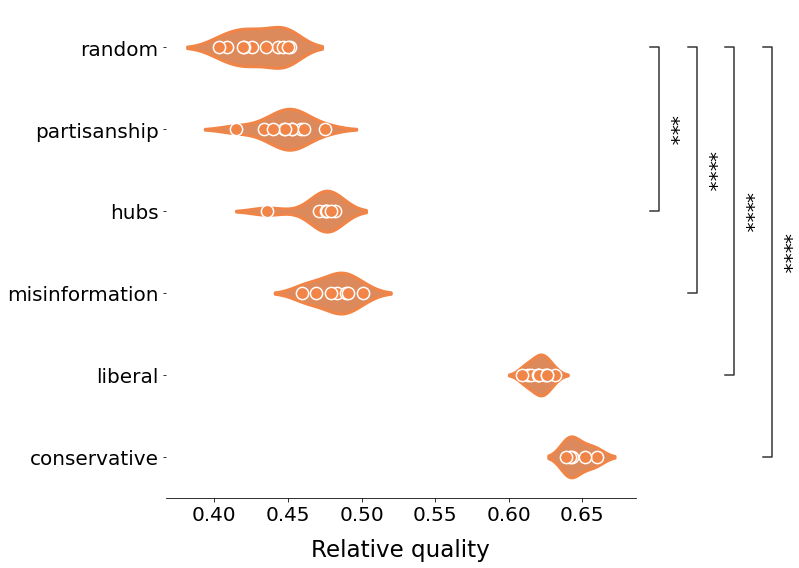

In [172]:
from statannotations.Annotator import Annotator

fpath = os.path.join(PLOT_DIR, "targeting")
color = "#F18447"  # orange

# change name of no targeting scenario
targetdata["targeting_criterion"] = targetdata["targeting_criterion"].apply(
    lambda x: "random" if x == "none" else x
)

order = ["random", "partisanship", "hubs", "misinformation", "liberal", "conservative"]

fig, ax = plt.subplots(figsize=(12, 8))
ax.yaxis.set_major_locator(plt.LinearLocator(5))
violin = sns.violinplot(
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    order=order,
    orient="h",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)
# Add statistical significance
pairs = [
    ("misinformation", "random"),
    ("liberal", "random"),
    ("hubs", "random"),
    ("conservative", "random"),
    #         ('partisanship', 'random') #insignificant
]
annotator = Annotator(
    ax,
    pairs,
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    orient="h",
    order=order,
)
annotator.configure(
    test="t-test_welch",
    text_format="star",
    loc="outside",
    fontsize=20,
    comparisons_correction=None,
)
annotator.apply_and_annotate()

# Format
violin.tick_params(axis="x", labelsize=20)
violin.tick_params(axis="y", labelsize=20)

violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize=23, labelpad=14)

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)
sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()